In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)
dftp = pd.read_csv('./data/taipei.csv',encoding = "ISO-8859-1")  # 

dftp = dftp.reindex(np.random.permutation(dftp.index))  # 打亂 df 的排序 np.random.permutation()

dftp.head(3)

,article,rating
145,STOCKSEarnings report boosts SonySony Corp sha...,1
345,Traditional May 1 union marches turned violent...,1
271,Antonio Conte on Sunday warned Chelsea not to ...,1


In [2]:
# 詞袋模型: 句子 -> 單字 -> 詞袋(稀疏矩陣)
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()

In [3]:
# 計算 TF-IDF, 使用 L2正規化 
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [4]:
# 文件清理
# 用正規表示式
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # 清除 HTML
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # 清除 標點符號
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '') # 非字元符號, - 
    return text

In [5]:
# 所有文本清除前
print(dftp['article'].head(20))

145    STOCKSEarnings report boosts SonySony Corp sha...
345    Traditional May 1 union marches turned violent...
271    Antonio Conte on Sunday warned Chelsea not to ...
14     More than 50 firms listed on the local main bo...
230    A: Whose idea was it to go to the shopping mal...
451    A regulation requiring that amateur radio oper...
718    Taipei resident Ho Po-han (????????°) on Tuesd...
771    A global cyberattack leveraging hacking tools ...
447    When President Tsai Ing-wen (?????±???) first ...
142    Mass-media company 21st Century Fox Inc is in ...
31     In February, former Executive Yuan director-ge...
740    The Executive Yuan yesterday approved two draf...
285    Chaz Wing was 12 when they cornered him in the...
693    The Executive Yuan yesterday approved two draf...
294    Chinese Nationalist Party (KMT) lawmakers yest...
210    North Korea observers have long marveled at th...
735    A legislative review of draft acts to reform t...
590    The Executive Yuan yeste

In [6]:
# 所有文本清除後
dftp['article'] = dftp['article'].apply(preprocessor)
print(dftp['article'].head(20))

145    stocksearnings report boosts sonysony corp sha...
345    traditional may 1 union marches turned violent...
271    antonio conte on sunday warned chelsea not to ...
14     more than 50 firms listed on the local main bo...
230    a whose idea was it to go to the shopping mall...
451    a regulation requiring that amateur radio oper...
718    taipei resident ho po han on tuesday vowed to ...
771    a global cyberattack leveraging hacking tools ...
447    when president tsai ing wen first started teac...
142    mass media company 21st century fox inc is in ...
31     in february former executive yuan director gen...
740    the executive yuan yesterday approved two draf...
285    chaz wing was 12 when they cornered him in the...
693    the executive yuan yesterday approved two draf...
294    chinese nationalist party kmt lawmakers yester...
210    north korea observers have long marveled at th...
735    a legislative review of draft acts to reform t...
590    the executive yuan yeste

In [7]:
# 文件轉為字符
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):  # 方法1. 空白字元斷字
    text = re.sub('<[^>]*>', '', text) # 清除 HTML
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # 清除 標點符號
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '') # 非字元符號, - 
    
    #text = re.sub('<[^>]*>', '', text)
    #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    #text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
    #return text.split()
def tokenizer_porter(text): # 方法2. 字詞 -> 字根
    tokenized=[porter.stem(word) for word in text.split()]
    return tokenized

In [8]:
# 命令提示字元 執行 pip install nltk
# 處理停用字(常見但又無用的字, is and or...)
import nltk
nltk.download('stopwords')

# 使用英文停用字集
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dftp.loc[:,'article'], dftp.loc[:, 'rating'], test_size=0.2, random_state=0)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# 網格法搜尋最佳參數組合
# TfidfVectorizer -> 字詞轉特徵值 與 計算TF-IDF
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
             ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, 
                           scoring='accuracy',
                           cv=5, verbose=1,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)
# 最佳參數組合
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.7s finished


Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [11]:
# 訓練資料集的套用最佳參數組合
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

CV Accuracy: 0.984


In [12]:
# 測試資料集套用最佳參數組合的正確率
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.981


In [13]:
import pickle #儲存訓練結果
import os

dest = os.path.join('ggept', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

In [14]:
clf.predict(X_test)

array([2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1])

In [15]:
clf.predict(X_train)

array([2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       2, 2,

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
from sklearn.learning_curve import learning_curve



#畫圖的function  plot_decision_regions
def learnCurve(classifier,train_vector, y_train,title):
    plt_title = title
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=classifier, 
                X=train_vector, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)
        

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,color='green', linestyle='--', marker='s', markersize=5,label='validation accuracy')

    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.1, 1.0])
    plt.tight_layout()
    plt.title(plt_title)
    # plt.savefig('./figures/learning_curve.png', dpi=300)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [17]:
# Perform classification with LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.fit_transform(X_test)

import time
classifier_Logistic = clf
t0 = time.time()
#Logistic_KNN = classifier_Logistic.fit(train_vectors, y_train)
t1 = time.time()
prediction_Logistic = classifier_Logistic.predict(X_test)
prediction_Logistic_score = accuracy_score(y_test, prediction_Logistic)  #評分方式 accuracy_score()
t2 = time.time()
time_Logistic_train = t1-t0
time_Logistic_predict = t2-t1

Results for LogisticRegression Taipei Times-Taipei Times 
Accuracy: 0.98
Training time: 0.000024s; Prediction time: 0.205331s
             precision    recall  f1-score   support

          1       1.00      0.97      0.98        91
          2       0.96      1.00      0.98        65

avg / total       0.98      0.98      0.98       156



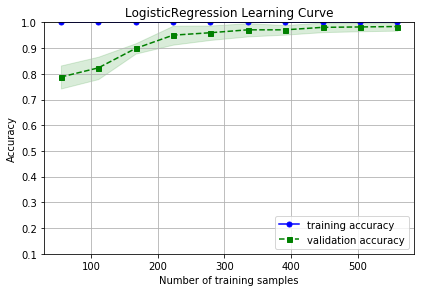

In [18]:

print("Results for LogisticRegression Taipei Times-Taipei Times ")
print('Accuracy: %.2f' % prediction_Logistic_score)
print("Training time: %fs; Prediction time: %fs" % (time_Logistic_train, time_Logistic_predict))
print(classification_report(y_test, prediction_Logistic))

learnCurve(classifier_Logistic,X_train,y_train,'LogisticRegression Learning Curve')
plt.show()